In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
%matplotlib inline
import calendar
import time

import boto
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from matplotlib import cm, colors
from sklearn import preprocessing
from sklearn.cross_decomposition import CCA

from src import plot_heatmaps

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def read_data(init):
    """
    Reads in forecast and error data from parquet files for the specified initialization time.
    The data includes GFS, NAM, and HRRR models for the years 2018-2021.

    Parameters:
    init (str): Initialization time of forecasts in "HH" format (00, 06, 12, or 18).

    Returns:
    Tuple of three pandas dataframes, containing the concatenated forecast and error data for GFS, NAM, and HRRR models.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # need to remove the random forecasts that have forecast hours 0
    # these are random because they only exist in the files that Ryan T. provided
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [4]:
def format_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Format the input DataFrame by filtering for lead times of 0 days and hours up to 18, and computing the average
    temperature error for each month and station.

    Args:
        df (pd.DataFrame): DataFrame containing temperature forecast and error data, including columns for
            lead_time_DAY, lead_time_HOUR, time, station, and t2m_error.

    Returns:
        pd.DataFrame: DataFrame containing the average temperature error for each month and station.
    """
    df = df[df["lead_time_DAY"] == 0]
    df = df[df["lead_time_HOUR"] <= 18]
    error_months = (
        (df.groupby([df.time.dt.month, "station"])[f"t2m_error"].mean())
        .to_frame()
        .reset_index()
    )
    return error_months

In [5]:
def canonical(lulc):
    """
    Calculates the canonical correlation between the error column and the other columns in the input DataFrame 'lulc'

    Parameters:
    -----------
    lulc : pandas.DataFrame
        The input DataFrame containing columns with land-use land-cover (LULC) classes and the error column.

    Returns:
    --------
    corr : float
        The canonical correlation coefficient between the error column and the LULC classes.
    """
    X = lulc.drop(columns="error")
    Y = lulc[["error"]]
    X_mc = (X - X.mean()) / (X.std())
    Y_mc = (Y - Y.mean()) / (Y.std())
    ca = CCA(n_components=1)
    ca.fit(X_mc, Y_mc)
    X_c, Y_c = ca.transform(X_mc, Y_mc)
    cc_res = pd.DataFrame(
        {
            "CCX_1": X_c[:, 0],
            "CCY_1": Y_c[:, 0],
            "11": lulc["11"].tolist(),
            "21": lulc["21"].tolist(),
            "22": lulc["22"].tolist(),
            "23": lulc["23"].tolist(),
            "24": lulc["24"].tolist(),
            "31": lulc["31"].tolist(),
            "41": lulc["41"].tolist(),
            "42": lulc["42"].tolist(),
            "43": lulc["43"].tolist(),
            "52": lulc["52"].tolist(),
            "71": lulc["71"].tolist(),
            "81": lulc["81"].tolist(),
            "82": lulc["82"].tolist(),
            "90": lulc["90"].tolist(),
            "95": lulc["95"].tolist(),
        }
    )
    corr = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    return corr

In [6]:
def main(months_df, lulc):
    """
    Calculates the canonical correlation coefficient between land use and land cover (LULC)
    and temperature error for each month in the given DataFrame of monthly temperature errors.
    The function uses the canonical() function to perform the calculation.

    Args:
    - months_df (pandas.DataFrame): A DataFrame of monthly temperature errors. The DataFrame
      should have a column named 'time' that represents the month, and a column named
      't2m_error' that represents the temperature error.
    - lulc (pandas.DataFrame): A DataFrame of land use and land cover (LULC) data. The DataFrame
      should have columns named '11', '21', '22', '23', '24', '31', '41', '42', '43', '52', '71',
      '81', '82', '90', and '95' representing different types of LULC, and a column named 'error'
      representing the temperature error.

    Returns:
    - corr_ls (list): A list of canonical correlation coefficients between LULC and temperature
      error for each month in the DataFrame of monthly temperature errors.
    """

    corr_ls = []
    for i in np.arange(1, 13):
        df = months_df[months_df["time"] == i]
        months = df["t2m_error"].to_list()
        lulc["error"] = months
        corr = canonical(lulc)
        corr_ls.append(corr)
    return corr_ls

In [7]:
def plot_heatmap(corr_ls):
    cal_ls = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
    df = pd.DataFrame(corr_ls, index=cal_ls)
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_title(f"Canonical Correlation Coefficients by Landtype for GFS")
    ax = sns.heatmap(df, vmin=0.3, vmax=1, cmap=cm.YlGnBu, annot=True)
    ax.set_ylabel("Month")
    ax.set_xlabel("CCA Coefficients")
    plt.tight_layout()

In [8]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [9]:
lulc = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/nlcd_gfs.csv")
lulc = lulc.drop(columns=["site", "station"])
keys = lulc.keys()

# GFS

In [10]:
months_df = format_df(gfs_fcast_and_error_df)

In [11]:
corr_ls = main(months_df, lulc)

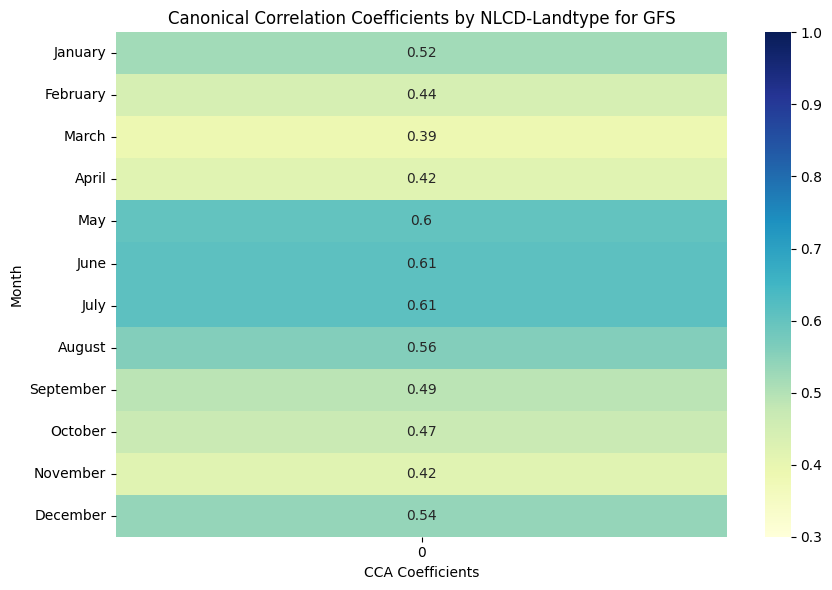

In [13]:
plot_heatmaps.plot_heatmap(corr_ls, "GFS", "NLCD-Landtype")

In [ ]:
# # Obtain the rotation matrices
# xrot = ca.x_rotations_
# yrot = ca.y_rotations_

# # Put them together in a numpy matrix
# xyrot = np.vstack((xrot,yrot))

# nvariables = xyrot.shape[0]

# plt.figure(figsize=(15, 15))
# plt.xlim((-1,1))
# plt.ylim((-1,1))

# # Plot an arrow and a text label for each variable
# for var_i in range(nvariables):
#   x = xyrot[var_i,0]
#   y = xyrot[var_i,1]

#   plt.arrow(0,0,x,y)
#   plt.text(x,y,data.columns[i], color='red' if i >= 6 else 'blue')

# plt.show()